In [1]:
# 使用models模块创建并训练神经网络模型
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

In [2]:
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

In [3]:
# 构造目标值, 并按照-10% 和10%截断(因为有涨跌停限制)
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna()
df["label"].clip(-0.1, 0.1, inplace=True) 
df["label"].describe()

count    1.197673e+06
mean     5.829445e-04
std      2.843395e-02
min     -1.000000e-01
25%     -1.330000e-02
50%      0.000000e+00
75%      1.370000e-02
max      1.000000e-01
Name: label, dtype: float64

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

CLOSE5   ROC5     BETA5       MA5      STD5  \
datetime   instrument                                                  
2006-04-07 000001.SZ   0.984544 -0.180  0.003091  1.006801  0.011801   
           000002.SZ   0.959004 -0.144  0.008199  1.009370  0.011831   
           000059.SZ   0.925408 -0.136  0.014918  0.968765  0.018250   
           000061.SZ   0.804309  0.018  0.039138  0.899820  0.078477   
           000063.SZ   0.972999 -0.030  0.005400  1.012706  0.017316   
...                         ...    ...       ...       ...       ...   
2022-12-28 688363.SH   0.913302  2.158  0.017340  0.977189  0.028128   
           688396.SH   1.014528 -0.354 -0.002906  1.003208  0.009834   
           688561.SH   0.938309  0.610  0.012338  1.005057  0.033432   
           688599.SH   0.855389  1.614  0.028922  0.930134  0.057758   
           688981.SH   1.009535 -0.278 -0.001907  1.007042  0.006198   

                           MAX5      MIN5     QTLU5     QTLD5   CLOSE10  ...  \
datetime   instrument                                                    ...   
2006-04-07 000001.SZ   1.020093  0.990726  1.016383  0.998145  0.975270  ...   
           000002.SZ   1.021962  0.995608  1.020791  0.999122  0.868228  ...   
           000059.SZ   1.000000  0.955711  0.975758  0.957576  0.955711  ...   
           000061.SZ   1.000000  0.829443  0.971275  0.829443  0.773788  ...   
           000063.SZ   1.040343  0.996188  1.018996  0.999238  0.930432  ...   
...                         ...       ...       ...       ...       ...  ...   
2022-12-28 688363.SH   1.014707  0.954703  1.002941  0.955350  0.950805  ...   
           688396.SH   1.013962  0.990377  1.012604  0.997623  1.074906  ...   
           688561.SH   1.031379  0.948972  1.024676  0.989794  0.992993  ...   
           688599.SH   1.000000  0.859216  0.969260  0.878603  0.871492  ...   
           688981.SH   1.014181  1.000000  1.013203  1.003130  1.040831  ...   

                       MEAN2_10  MEAN2_20  MEAN2_30  MEAN2_60   AMOUNT5  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.978529  0.958139  1.077550  0.969214  0.847906   
           000002.SZ   0.865644  0.732006  0.816881  0.651620  0.846304   
           000059.SZ   1.006254  0.878924  0.966881  0.795894  0.334477   
           000061.SZ   0.795945  0.803208  0.830703  0.782898  0.201339   
           000063.SZ   0.933128  0.867431  0.942097  0.921683  0.433476   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.938007  0.802368  0.840133  0.980244  0.391778   
           688396.SH   1.089137  0.996531  1.017298  0.900445  1.674625   
           688561.SH   0.991060  0.925343  1.039368  0.684092  0.494056   
           688599.SH   0.882503  1.052199  1.064043  1.083195  0.528563   
           688981.SH   1.050083  0.996821  1.044376  0.924189  1.126837   

                       AMOUNT10  AMOUNT20  AMOUNT30  AMOUNT60     label  
datetime   instrument                                                    
2006-04-07 000001.SZ   0.586163  0.845426  2.391277  1.251323  0.026700  
           000002.SZ   0.604176  0.228810  0.560573  0.493426  0.025300  
           000059.SZ   2.274942  0.478818  0.650543  0.194657 -0.020700  
           000061.SZ   0.097644  0.105429  0.429122  0.471194 -0.001800  
           000063.SZ   0.575827  0.158053  0.329017  0.588615 -0.007900  
...                         ...       ...       ...       ...       ...  
2022-12-28 688363.SH   0.947322  0.719363  1.316014  0.427300 -0.001550  
           688396.SH   4.719745  1.218943  2.626182  1.643164 -0.004161  
           688561.SH   1.735394  1.894400  1.826660  1.045160  0.004736  
           688599.SH   0.575414  0.813492  0.810529  0.576380  0.008861  
           688981.SH   5.155468  1.256573  3.713760  0.867828  0.006114  

[1141117 rows x 146 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1141117 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 146 entries, CLOSE5 to label
dtypes: float64(146)
memory usage: 1.2+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


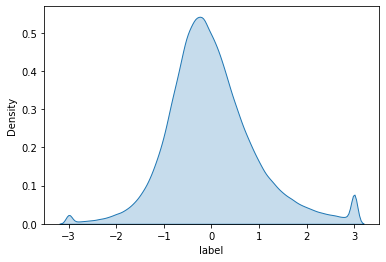

The distribution of y_valid:


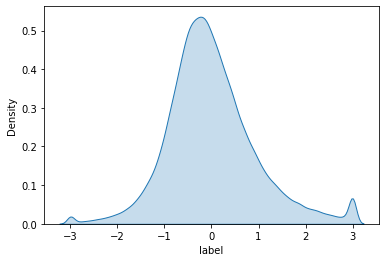

The distribution of y_test:


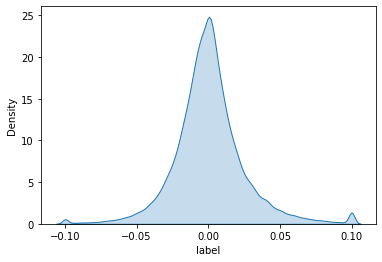

norm data done 

all works done 



In [5]:
split_params = {
    "test_date": "2019-01-01",
    "split_method": "split",
    "split_kwargs":{
        "train": 0.7,
        "valid": 0.3
    }
}

# 从训练集中按7：3的比例随机拆分出验证集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

In [6]:
from scutquant import models

attention = models.Attention(epochs=30)
attention.fit(X_train, y_train, X_valid, y_valid)

pred = attention.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean
pred["predict"] *= ystd

pred.describe()

Epoch 1/30
2353/2353 [==============================] - 80s 34ms/step - loss: 1.0677 - mae: 0.7335 - mape: 2112.2957 - val_loss: 1.0010 - val_mae: 0.7104 - val_mape: 1763.6583
Epoch 2/30
2353/2353 [==============================] - 83s 35ms/step - loss: 0.9734 - mae: 0.7075 - mape: 770.3717 - val_loss: 0.9548 - val_mae: 0.7112 - val_mape: 783.0722
Epoch 3/30
2353/2353 [==============================] - 80s 34ms/step - loss: 0.9237 - mae: 0.7047 - mape: 667.5632 - val_loss: 0.9149 - val_mae: 0.7062 - val_mape: 739.5335
Epoch 4/30
2353/2353 [==============================] - 81s 35ms/step - loss: 0.8972 - mae: 0.7042 - mape: 656.7341 - val_loss: 0.9012 - val_mae: 0.7061 - val_mape: 874.4678
Epoch 5/30
2353/2353 [==============================] - 83s 35ms/step - loss: 0.8935 - mae: 0.7042 - mape: 661.8511 - val_loss: 0.9096 - val_mae: 0.7077 - val_mape: 575.9940
Epoch 6/30
2353/2353 [==============================] - 84s 36ms/step - loss: 0.8926 - mae: 0.7040 - mape: 678.4144 - val_loss: 

,predict
count,280721.000000
mean,-0.000360
std,0.001860
min,-0.021435
25%,-0.001180
50%,-0.000194
75%,0.000652
max,0.016503


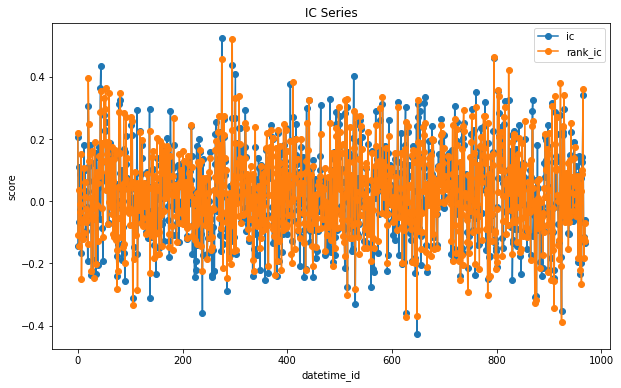

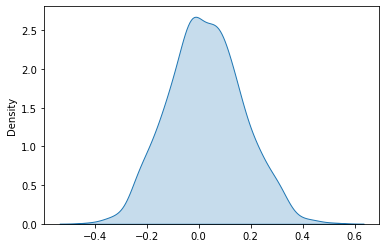

ic= 0.025236882727623873 icir= 0.17618266312229258 rank_ic= 0.026884862050809265 rank_icir= 0.19300256336643565


0.10560602304149033

In [7]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred.values, y_test)
r[0]